In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm 
import scipy.stats as stats 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
housing = pd.read_csv('california_housing.csv')

#Checking the dataset
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15,5612,1283,1015,472,1.4936,66900
1,-114.47,34.40,19,7650,1901,1129,463,1.8200,80100
2,-114.56,33.69,17,720,174,333,117,1.6509,85700
3,-114.57,33.64,14,1501,337,515,226,3.1917,73400
4,-114.57,33.57,20,1454,326,624,262,1.9250,65500


In [3]:
#Exploring the dataset
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           17000 non-null  float64
 1   latitude            17000 non-null  float64
 2   housing_median_age  17000 non-null  int64  
 3   total_rooms         17000 non-null  int64  
 4   total_bedrooms      17000 non-null  int64  
 5   population          17000 non-null  int64  
 6   households          17000 non-null  int64  
 7   median_income       17000 non-null  float64
 8   median_house_value  17000 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 1.2 MB


In [4]:
#All data are numeric variables.
#There is no missing values. That's great. But, one more thing to check. I want to check if there is any 0's in the dataset.
df = pd.DataFrame(housing)
zero_counts = (df == 0).sum()
zero_counts

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
dtype: int64

In [5]:
#Great. There is no 0 variables in the dataset.

#In order to predict the housing price in San Diego later, I am going to extract San Diego information.
#Here are longitude and latitude of San Diego, 32.71 & -117.16
#Very North of San Diego is Oceanside and its latitude and longitude are 33.19 & -117.37.
#Very South of San Diego is the boarder between Mexico and California. It's at 32.54 & -116.96.
#This is why I decided to use the range of +,- 0.2.
latitude_sd_min = 32.71 - 0.2
atitude_sd_max = 32.71 + 0.2
longitude_sd_min = -117.16 - 0.2
longitude_sd_max = -117.16 + 0.2

San_Diego = df[(df['latitude'] >= latitude_sd_min) & (df['latitude'] <= atitude_sd_max) & 
               (df['longitude'] >= longitude_sd_min) & (df['longitude'] <= longitude_sd_max)]
San_Diego

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
433,-116.96,32.90,16,3047,495,1507,499,5.3008,186500
434,-116.96,32.87,17,4713,740,2531,723,4.8286,158500
435,-116.96,32.86,14,3064,496,1681,503,4.4347,160300
436,-116.96,32.85,11,9724,1796,5247,1777,4.1716,166100
437,-116.96,32.81,8,2378,638,1410,623,2.9097,152500
...,...,...,...,...,...,...,...,...,...
1900,-117.28,32.74,33,4168,1112,1785,984,2.7515,247700
1901,-117.28,32.73,44,1934,325,783,316,4.8684,358600
1937,-117.29,32.81,35,1878,308,598,257,6.9553,500001
2008,-117.31,32.83,38,2367,480,891,428,4.1477,500001


In [6]:
#It looks like there 857 rows of information,which is about 5% of the whole dataset.
#I am going to use that row after choosing the best model to predict the housing price in SD.
#Here is the dataset without the San Diego information.
df_new = df.drop(San_Diego.index)

#Checking the row count.
print(f'Original: {len(df)}')
print(f'New Datafame without San Diego: {len(df_new)}')

Original: 17000
New Datafame without San Diego: 16143


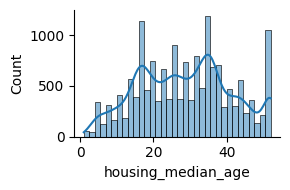

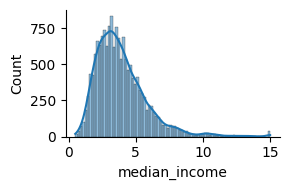

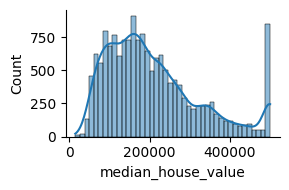

In [7]:
#Now, let's check distributions of each feature using the df_new dataframe. 
#I would like to focus on the distributions of housing_median_age, median_income 
#and median_house_value. 
reduced_feature1 = ["housing_median_age","median_income", "median_house_value"]
for feature in reduced_feature1:
    sns.displot(df_new[feature], kde= True, height =2, aspect= 1.5)

<Axes: >

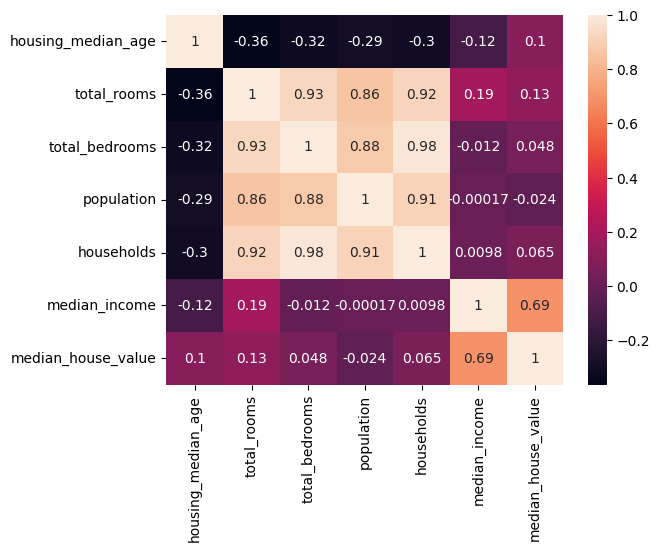

In [8]:
#The first plot, which is housing_media_age, seems like it's not a perfect normal distribution shape 
#but also not really skewed to left or right.

#The second plot, which is median_income, seems like there is a long tail on the right side. 
#I am going to check if there are some outliers on median_income later on.

#Lastly, median_houw_value is the target value but it looks like it's right-skewed 
#due to the count that houses cost more than 500,000 dollars are just counted as 500,000 dollars.
#I am going to normalize this later after I exlopre some more.

#Let's check if there is any correlation between features and also between features and the target.
reduced_feature2 = ["housing_median_age","total_rooms", "total_bedrooms", "population", "households", "median_income", "median_house_value"]
sns.heatmap(df_new[reduced_feature2].corr(), annot= True)



Text(0, 0.5, 'House Value')

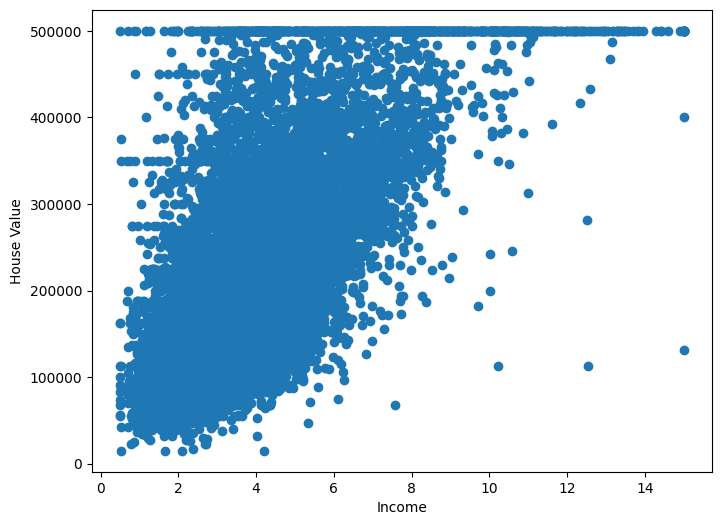

In [9]:
#The target variable is median_house_value so focus on that row, which is the bottom row on the heatmap.
#It looks like the target variable correlates the most with median_income, which is the highest value on the heatmap, 0.69.
#Correlation with the target: median_income > total_tooms > housing_median_age > households > total_bedrooms > population
#Other than that, total_rooms, total_bedrooms, population and houeholds are correlate to one another, and this correlation
#makes sense. More population = bigger households = need more rooms.

#Deeper investigation on median_house_value and median_income correlation.
plt.figure(figsize=(8,6))
plt.scatter(data= df_new, x="median_income", y="median_house_value")
plt.xlabel("Income")
plt.ylabel("House Value")

<Axes: xlabel='longitude', ylabel='latitude'>

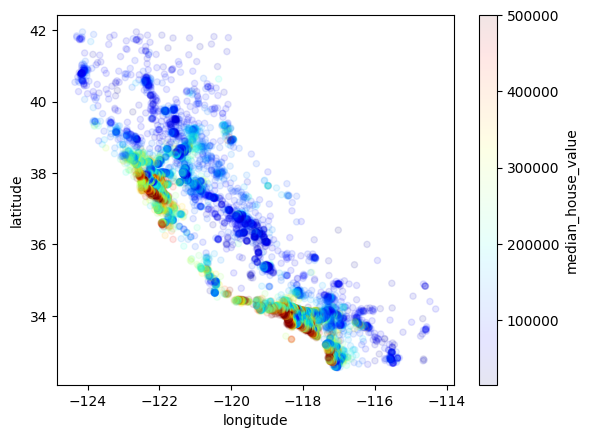

In [10]:
#It looks like when the median_income increases, median_house_value also increases. This makes sense.

#Plot Longitute and Latitude in different color based on median_house_value
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1,
             c="median_house_value", cmap=plt.get_cmap("jet"))

<Axes: xlabel='households'>

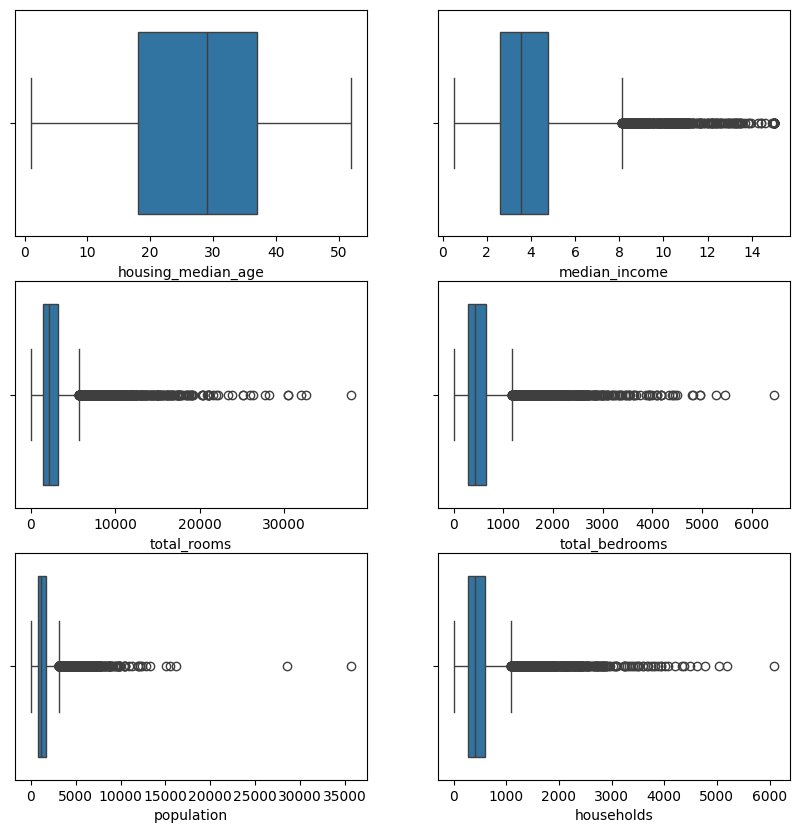

In [11]:
#This plot is the shape of California. San Francisco bay area, Los Angeles and San Diego areas are red which means
#the median_house_value is high. The house value near the coast line is higher than the houses in inland area.

#Plot boxplots to check outliers.
fig, axes = plt.subplots(3,2, figsize= (10,10))
sns.boxplot(data = df_new, x= "housing_median_age", ax = axes[0,0])
sns.boxplot(data = df_new, x= "median_income", ax = axes[0,1])
sns.boxplot(data = df_new, x= "total_rooms", ax = axes[1,0])
sns.boxplot(data = df_new, x= "total_bedrooms", ax = axes[1,1])
sns.boxplot(data = df_new, x= "population", ax = axes[2,0])
sns.boxplot(data = df_new, x= "households", ax = axes[2,1])


In [12]:
#house_median_age seems like there is no outliers.
#median_income has a lot of outliers.
#total_rooms has like 4 outliers
#total_bedrooms has 3 outliers.
#population has 2 obvious outliers.
#households has 3 outliers.

#Now we know that there are some quite few outliers for each feature. 
#Count outliers.
reduced_feature2 = ["housing_median_age","total_rooms", "total_bedrooms", "population", "households", "median_income", "median_house_value"]

def count_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data <= lower_bound) | (data >= upper_bound)]
    return outliers.count()

for feature in reduced_feature2:
    result= count_outliers(df_new[feature])
    print(f'{feature}: {result}')
    


housing_median_age: 0
total_rooms: 1036
total_bedrooms: 1035
population: 973
households: 993
median_income: 534
median_house_value: 847


In [13]:
#There are a lot of outliers. It is impossible to remove all of them.
#The total_rooms, total_bedrooms, population and households featutres are closely correlated to 
#each other so I am not going to remove any outliers from them.
#The outliers of median_income seems like it's just representing some wealthy neighborhoods in California.
#Therefore, I would not remove any outliers.

Text(0.5, 1.0, 'Distribution Plot Before Nomalizing House Value')

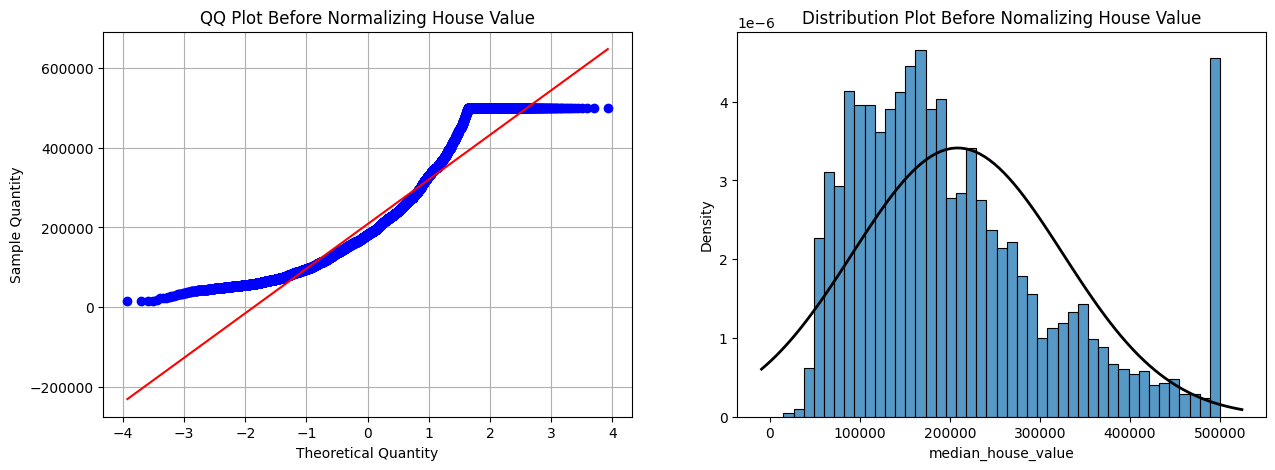

In [14]:
#Now, it's time to normalize the target variable, which was not normally distributed.

#Here are qq-plot & distribution graphs with originial data, before normalizing them.
fig, ax = plt.subplots(1,2, figsize= (15,5)) 
stats.probplot(df_new["median_house_value"], dist="norm", plot=ax[0])
ax[0].set_title('QQ Plot Before Normalizing House Value')
ax[0].set_ylabel('Sample Quantity')
ax[0].set_xlabel('Theoretical Quantity')
ax[0].grid(True)

sns.histplot(df["median_house_value"], kde= False, stat="density", ax=ax[1])
mu, std = stats.norm.fit(df_new["median_house_value"])
xmin, xmax = ax[1].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
ax[1].plot(x, p, 'k', linewidth=2)
ax[1].set_title('Distribution Plot Before Nomalizing House Value')

Text(0.5, 1.0, 'Distribution Plot After Nomalizing House Value')

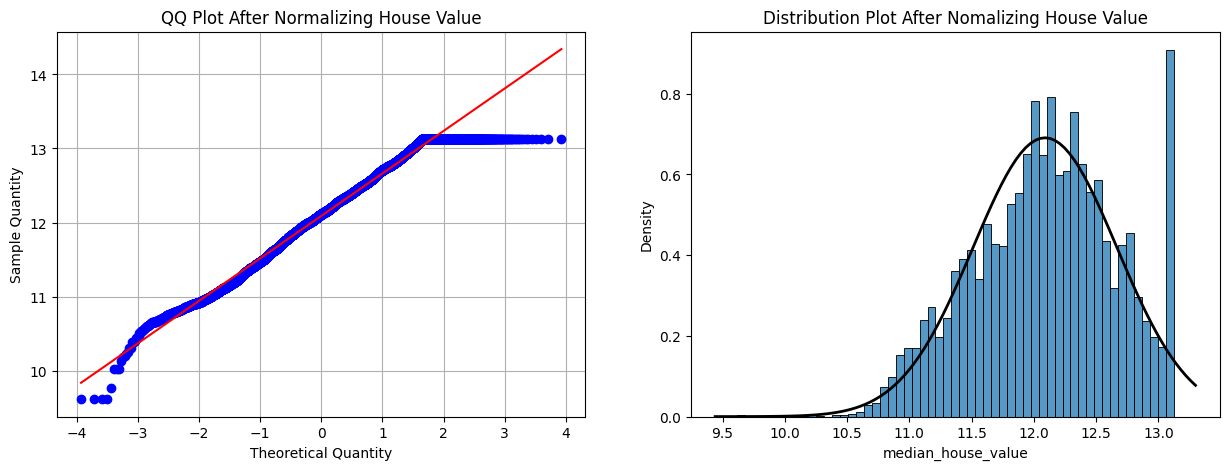

In [15]:
#The data is definitely not lying on the QQ plot's reference line.
#The distribution plot shows that the normal distribution line is not lying on top of the histogram bars.

#Normalize the target variable using log(1+x). I chose log(1+x) over just log(x) because log(1+x) is more stable
#when the input values are close to 0.
df_norm = df_new.copy()
df_norm['median_house_value'] = np.log1p(df["median_house_value"])

#Let's visualize the logarithmic transformed target variable.
ig, ax = plt.subplots(1,2, figsize= (15,5)) 
stats.probplot(df_norm['median_house_value'], dist="norm", plot=ax[0])
ax[0].set_title('QQ Plot After Normalizing House Value')
ax[0].set_ylabel('Sample Quantity')
ax[0].set_xlabel('Theoretical Quantity')
ax[0].grid(True)

sns.histplot(df_norm['median_house_value'], kde= False, stat="density", ax=ax[1])
mu, std = stats.norm.fit(df_norm['median_house_value'])
xmin, xmax = ax[1].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
ax[1].plot(x, p, 'k', linewidth=2)
ax[1].set_title('Distribution Plot After Nomalizing House Value')

In [16]:
#The data points on QQ plot are not curved up anymore, they are fitting on the reference line after the log(1+x) normalization.
#The distribution also fit to the normal distribution line better now.

#Time to split the dataset to training, cross-validation and testing datasets for modeling.
target_y = df_norm['median_house_value']
features_x = df_norm.drop(['median_house_value'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(features_x, target_y, test_size = 0.2, random_state = 1)

#Scale the input variables.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


#Set up functions for evaluation metrics.
#Frist one is R-squared score using cross-validation.
def calculate_rsquare(model, X, y, cv=3):
    scores = cross_val_score(model, X, y, cv = cv, scoring = 'r2')
    print("Score of average R-Squared: ", scores.mean())
    

#Mean Squared Error using cross-validation.
def calculate_mse(model, X, y, cv=3):
    scores = cross_val_score(model, X, y, cv=cv, scoring= 'neg_mean_squared_error')
    mse_scores = -scores
    print("MSE is ", mse_scores.mean())
    

In [17]:
#Linear Regression Model
linear_regression_model = LinearRegression()
linear_regression_model.fit(X_train, y_train)
calculate_rsquare(linear_regression_model, X_train, y_train)
calculate_mse(linear_regression_model, X_train, y_train)

Score of average R-Squared:  0.6544859921552535
MSE is  0.11623145344120978


In [18]:
#Ridge Regression Model
ridge_regression_model1 = Ridge(alpha=100)
ridge_regression_model1.fit(X_train, y_train)
calculate_rsquare(ridge_regression_model1, X_train, y_train)
calculate_mse(ridge_regression_model1, X_train, y_train)

ridge_regression_model2 = Ridge(alpha=10)
ridge_regression_model2.fit(X_train, y_train)
calculate_rsquare(ridge_regression_model2, X_train, y_train)
calculate_mse(ridge_regression_model2, X_train, y_train)

ridge_regression_model3 = Ridge(alpha=1)
ridge_regression_model3.fit(X_train, y_train)
calculate_rsquare(ridge_regression_model3, X_train, y_train)
calculate_mse(ridge_regression_model3, X_train, y_train)

Score of average R-Squared:  0.652116794500215
MSE is  0.11700954991182871
Score of average R-Squared:  0.6545331620148461
MSE is  0.11621324276332057
Score of average R-Squared:  0.6544946358247379
MSE is  0.11622830621293219


In [19]:
#Choosing the alpha parameter in ridge regression is important because it controls the regularization strength.
#I tested out 100, 10 and 1 for alpha value and it looks like 10 resulted the highest R-squared score and
#the lowest MSE. Therefore, I am going to choose the R-Squared and MSE result using alpha=10.
final_ridge_regression_model = ridge_regression_model2

In [20]:
#Support Vector Regression (SVR)
svr_model = SVR()
svr_model.fit(X_train, y_train)
calculate_rsquare(svr_model, X_train, y_train)
calculate_mse(svr_model, X_train, y_train)

Score of average R-Squared:  0.7871881766678165
MSE is  0.07157613206451054


In [21]:
#The R-square of SVR is negatiave and this indicates that SVR model is performing very poorly.

#Decision Tree Regressor
decision_tree_model = DecisionTreeRegressor(random_state=0)
decision_tree_model.fit(X_train, y_train)
calculate_rsquare(decision_tree_model, X_train, y_train)
calculate_mse(decision_tree_model, X_train, y_train)

Score of average R-Squared:  0.67396827912752
MSE is  0.10958331374058213


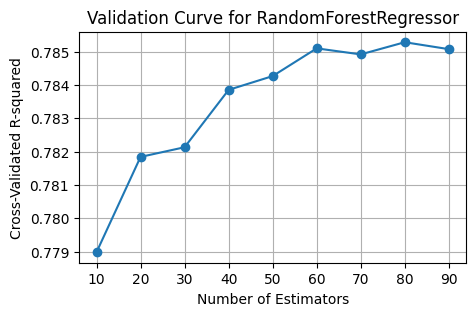

In [22]:
#Random Forest Regressor
#Testing out what n_estimator value performs the best.
#Range from 10 to 100.
n_estimators_range = np.arange(10, 100, 10)
cv_scores = []

for n in n_estimators_range:
    model = RandomForestRegressor(n_estimators=n, max_depth=8, random_state=0)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    cv_scores.append(scores.mean())

plt.figure(figsize=(5, 3))
plt.plot(n_estimators_range, cv_scores, marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Cross-Validated R-squared')
plt.title('Validation Curve for RandomForestRegressor')
plt.grid(True)
plt.show()

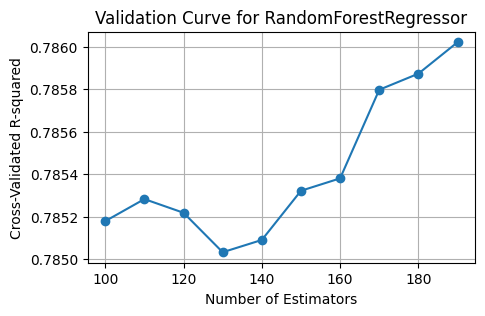

In [23]:
#Range from 100 to 200
n_estimators_range = np.arange(100, 200, 10)
cv_scores = []

for n in n_estimators_range:
    model = RandomForestRegressor(n_estimators=n, max_depth=8, random_state=0)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    cv_scores.append(scores.mean())

plt.figure(figsize=(5, 3))
plt.plot(n_estimators_range, cv_scores, marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Cross-Validated R-squared')
plt.title('Validation Curve for RandomForestRegressor')
plt.grid(True)
plt.show()


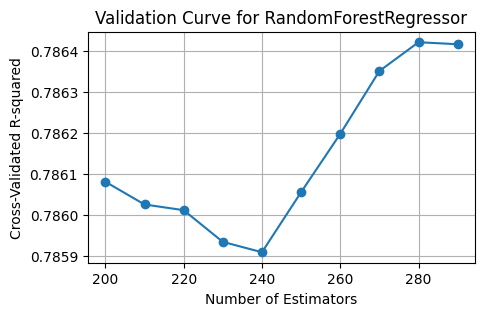

In [24]:
#Range from 200 to 300.
n_estimators_range = np.arange(200, 300, 10)
cv_scores = []

for n in n_estimators_range:
    model = RandomForestRegressor(n_estimators=n, max_depth=8, random_state=0)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    cv_scores.append(scores.mean())

plt.figure(figsize=(5, 3))
plt.plot(n_estimators_range, cv_scores, marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Cross-Validated R-squared')
plt.title('Validation Curve for RandomForestRegressor')
plt.grid(True)
plt.show()

In [25]:
#Testing out the highest n_estimator on the first graph, n_estimator = 90.
random_forest_model1 = RandomForestRegressor(n_estimators = 90, max_depth= 8, random_state=0)
random_forest_model1.fit(X_train, y_train)
calculate_rsquare(random_forest_model1, X_train, y_train)
calculate_mse(random_forest_model1, X_train, y_train)

Score of average R-Squared:  0.7819501962473008
MSE is  0.07335867423981568


In [26]:
#Testing out the highest n_estimator on the second graph, n_estimator = 190.
random_forest_model2 = RandomForestRegressor(n_estimators = 190, max_depth= 8, random_state=0)
random_forest_model2.fit(X_train, y_train)
calculate_rsquare(random_forest_model2, X_train, y_train)
calculate_mse(random_forest_model2, X_train, y_train)

Score of average R-Squared:  0.7824942208300953
MSE is  0.07317509893307146


In [73]:
#Testing out the highest n_estimator on the last graph, n_estimator = 280.
random_forest_model3 = RandomForestRegressor(n_estimators = 280, max_depth= 8, random_state=0)
random_forest_model3.fit(X_train, y_train)
calculate_rsquare(random_forest_model3, X_train, y_train)
calculate_mse(random_forest_model3, X_train, y_train)

Score of average R-Squared:  0.7829518917125333
MSE is  0.0730186025063499


In [72]:
#Choosing the best performed n_estimator results the higher Score on R-squared and lower MSE value.
#Therefore, I am choosing n_estimator = 290.
final_random_forest_model = random_forest_model3

In [29]:
#Gradient boosting model
#There are n_estimator, learning_rate and max_depth as parameters for gradient boosting model.
#Let's figure out the best performing parameter sets.
param_grid = {'n_estimators': [100,150,190,300],'learning_rate': [0.01, 0.1,0.25,0.5],
    'max_depth': [1, 5, 10, 15]}

grid_search = GridSearchCV(estimator=GradientBoostingRegressor(random_state=0),
    param_grid=param_grid,cv=5,scoring='r2',n_jobs=-1,verbose=1)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
Best Score: 0.8465960241172186


In [31]:
#The best parameters are learning_rate: 0.1, max_depth: 5, and e_estimator: 300.
gradient_boosting_model = GradientBoostingRegressor(random_state = 0, n_estimators = 300, learning_rate = 0.1, max_depth = 5) 
gradient_boosting_model.fit(X_train, y_train)
calculate_rsquare(gradient_boosting_model, X_train, y_train)
calculate_mse(gradient_boosting_model, X_train, y_train)


Score of average R-Squared:  0.8424480701652054
MSE is  0.05298654930428041


In [33]:
#Gradient boosting model got the highest R-squared score and the lowest MSE.
#Therefore, this is the best model for the dataset! 

#Confrim the model performance with the test dataset.
calculate_rsquare(gradient_boosting_model, X_test, y_test)
calculate_mse(gradient_boosting_model, X_test, y_test)

Score of average R-Squared:  0.7943200082133792
MSE is  0.06629220609760657


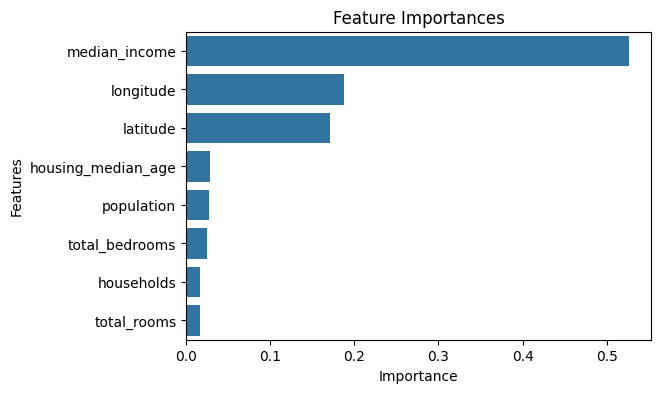

In [34]:
#Even with the test dataset, gradient boosting model performed better than
#other models on the training dataset.

#Using gradient boosting model, let's find the most important feature.
#Earlier, according to the heatmap, median_income was the most correlated feature 
#with the target variable.
feature_imp = gradient_boosting_model.feature_importances_
feature_imp_df = pd.DataFrame({'Features': features_x.columns, 'Importance': feature_imp})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(6, 4))
sns.barplot(x='Importance', y='Features', data=feature_imp_df, orient='h')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.show()

In [35]:
#Now it is confirmed that the most correlated feature with the target variable and
#the most important feature is median_income.

In [37]:
#One last step, let's predict housing price in San Diego with the model performed the best.
#Before the final prediction, the San Diego data needs to be scaled first.
#Before scaling the data, drop the target variable in San_Diego data.
San_Diego_new = San_Diego.drop(['median_house_value'], axis=1)
scaled_sd = scaler.transform(San_Diego_new)


In [49]:
#Preidct median_house_value in San Diego.
final_prediction = gradient_boosting_model.predict(scaled_sd)
final_prediction_scale = np.exp(final_prediction) - 1
print(f'Median House Value(prediction) in San Diego is {final_prediction_scale[0]}')

#Median housing value in San_Diego.
median = San_Diego['median_house_value'].median()
print(f'Median House Value(actual) in San Diego is {median}')

Median House Value(prediction) in San Diego is 196739.06249797446
Median House Value(actual) in San Diego is 158900.0


In [57]:
#Difference between actual median value from San_Diego and the prediction.
Difference = abs(median-final_prediction_scale[0])/median * 100
print(f'Difference between actual and prediction is {Difference}%')

Difference between actual and prediction is 23.81312932534579%


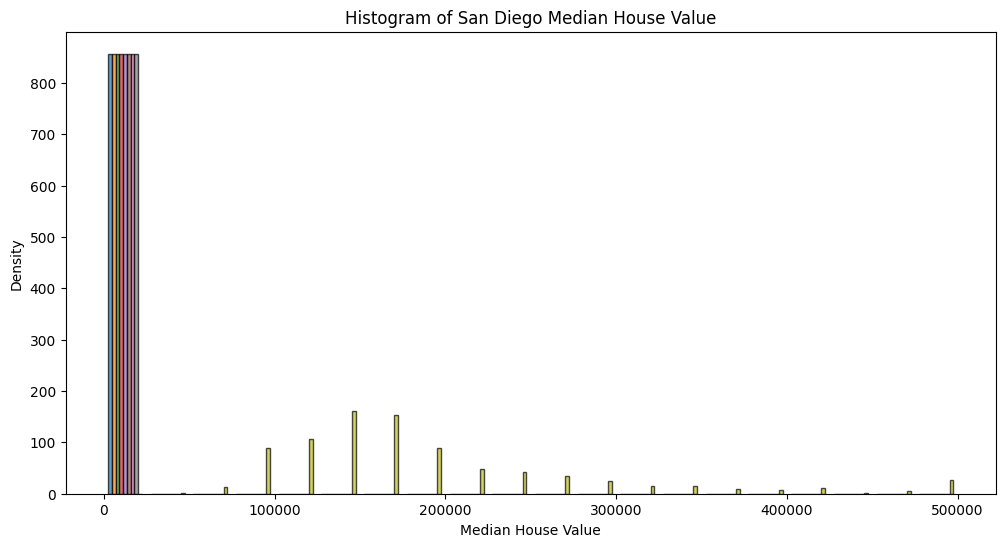

Minimum Median House Value is 47500
Maximum Median House Value is 500001


In [69]:
#The difference is little bit over 20% which I think it's pretty high.
#The median house value is the middle value in the dataset and the dataset could be skewed,
#so let's check the distribution.
plt.figure(figsize=(12, 6))
plt.hist(San_Diego, bins=20, edgecolor='black', alpha=0.7)
plt.title('Histogram of San Diego Median House Value')
plt.xlabel('Median House Value')
plt.ylabel('Density')
plt.show()
max_value = San_Diego['median_house_value'].max()
min_value = San_Diego['median_house_value'].min()

print(f'Minimum Median House Value is {min_value}')
print(f'Maximum Median House Value is {max_value}')

In [70]:
#It is very skewed to the lower value side.
#In this case, using the average of actual median house value makes more sense to me.
average_house_value_sd = San_Diego['median_house_value'].mean()
print(f'Average Median House Value in San Diego is {average_house_value_sd}')

Average Median House Value in San Diego is 184990.9218203034


In [71]:
#Difference between the average of actual median house value and the prediction.
Difference2 = abs(average_house_value_sd-final_prediction_scale[0])/median * 100
print(f'Difference between actual and prediction is {Difference2}%')

Difference between actual and prediction is 7.393417670025842%


In [ ]:
#7% difference is great!